In [2]:
# ============================================
# Step 2: Install dependencies
# ============================================
!pip install -q gdown torchsummary huggingface_hub

In [3]:
# ============================================
# Step 3: Import libraries
# ============================================
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
from torchsummary import summary
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from PIL import ImageFile
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import gc
from huggingface_hub import HfApi, login, create_repo, hf_hub_download
from kaggle_secrets import UserSecretsClient

In [4]:
os.makedirs("/kaggle/working/xAI", exist_ok=True)
%cd /kaggle/working/xAI

/kaggle/working/xAI


In [5]:
# ============================================
# Step 4: Download pretrained checkpoint
# ============================================
from huggingface_hub import hf_hub_download

ckpt_path = hf_hub_download(
    repo_id="poloclub/robust-principles",      # keep your repo id
    filename="ra_wrn70_16_cifar10.pt",
    local_dir="/kaggle/working/xAI",                             # put into current directory
    local_dir_use_symlinks=False               # copy the file (not a symlink)
)

print("✅ Now in CWD at:", ckpt_path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


ra_wrn70_16_cifar10.pt:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

✅ Now in CWD at: /kaggle/working/xAI/ra_wrn70_16_cifar10.pt


In [6]:
# ---------------------------
# Step 5: Setup
# ---------------------------
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)

data_root = "/kaggle/input/fracatlas"
write_dir = "/kaggle/working/fracatlas"

class_names = ["not fractured", "fractured"]

In [7]:
# ---------------------------
# Step 6: Collect fractured + non-fractured images
# ---------------------------
# Fractured: train + test dirs combined
fractured_imgs = []
for subdir in ["train", "test", "val"]:
    img_dir = os.path.join(data_root, subdir, "img")
    if os.path.exists(img_dir):
        fractured_imgs.extend([os.path.join(img_dir, x) for x in os.listdir(img_dir)])

# Non-fractured
nonfractured_imgs = [os.path.join(data_root, "not fractured", "img", x)
                     for x in os.listdir(os.path.join(data_root, "not fractured", "img"))]

print(f"Total fractured images: {len(fractured_imgs)}")
print(f"Total non-fractured images: {len(nonfractured_imgs)}")

Total fractured images: 717
Total non-fractured images: 3366


In [8]:
# ---------------------------
# Optional Undersampling (to balance a bit)
# ---------------------------
# Reduce number of non-fractured samples
target_nonfractured = 1500
if len(nonfractured_imgs) > target_nonfractured:
    nonfractured_imgs = random.sample(nonfractured_imgs, target_nonfractured)
print(f"Using {len(nonfractured_imgs)} non-fractured images after undersampling.")

Using 1500 non-fractured images after undersampling.


In [9]:
# ---------------------------
# 7. Reorganize into ImageFolder format
# ---------------------------
# Structure after this step:
#   write_dir/
#       fractured/
#       not fractured/
shutil.rmtree(write_dir, ignore_errors=True)
os.makedirs(os.path.join(write_dir, "fractured"), exist_ok=True)
os.makedirs(os.path.join(write_dir, "not fractured"), exist_ok=True)

# Copy fractured
for img in fractured_imgs:
    shutil.copy(img, os.path.join(write_dir, "fractured"))

# Copy non-fractured
for img in nonfractured_imgs:
    shutil.copy(img, os.path.join(write_dir, "not fractured"))

In [10]:
# ---------------------------
# Transforms
# ---------------------------
# Standard normalization
normalize_transform = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2470, 0.2435, 0.2616]
)

# Stronger augmentation for fractured samples
fracture_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_transform
])

# Regular transform (for all images)
base_aug = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_transform
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize_transform
])

In [11]:
# ---------------------------
# Custom Dataset Wrapper to Apply Class-Specific Augmentations
# ---------------------------
class AugmentedImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            # Apply stronger augmentation for fractured (class 1)
            if target == 1:
                sample = fracture_aug(sample)
            else:
                sample = base_aug(sample)
        return sample, target

In [12]:
# ---------------------------
# Dataset Creation
# ---------------------------
full_dataset = AugmentedImageFolder(root=write_dir, transform=None)
print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

# ---------------------------
# Stratified Train/Val/Test Split (80/10/10)
# ---------------------------
all_indices = list(range(len(full_dataset)))
all_labels = [full_dataset.samples[i][1] for i in all_indices]

# First split: Train (80%) vs Temp (20%)
train_idx, temp_idx, y_train, y_temp = train_test_split(
    all_indices, all_labels, stratify=all_labels, test_size=0.2, random_state=42
)

# Second split: Val (10%) vs Test (10%) from Temp
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp, stratify=y_temp, test_size=0.5, random_state=42
)

# Subset datasets
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# Assign transforms
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# ---------------------------
# Weighted Sampling (Oversampling)
# ---------------------------
targets = [full_dataset.samples[i][1] for i in train_dataset.indices]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Classes: ['fractured', 'not fractured']
Total images: 2217


In [23]:
# ---------------------------
# DataLoaders
# ---------------------------
batch_size = 8
ImageFile.LOAD_TRUNCATED_IMAGES = True

dl_train = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0)
dl_val   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
dl_test  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 1773, Val: 222, Test: 222


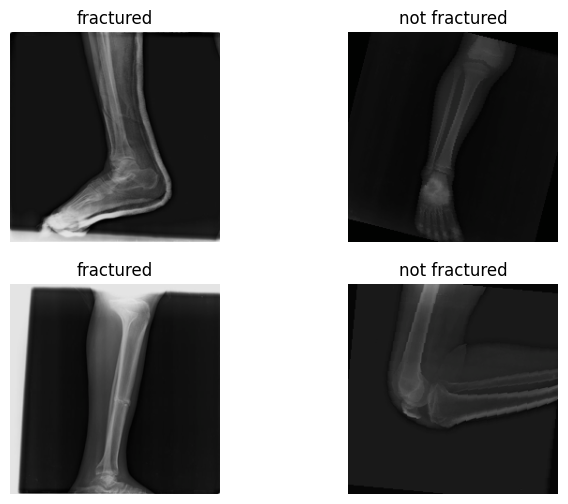

In [24]:
# Function to denormalize (undo ImageNet normalization for display)
def denormalize(img_tensor):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std  = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.numpy().transpose((1, 2, 0))   # CHW -> HWC
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Function to show a batch of images
def show_batch(dataloader, dataset, n=6):
    images, labels = next(iter(dataloader))
    class_names = dataset.dataset.classes  # ['fractured', 'not fractured']

    plt.figure(figsize=(8, 6))
    for i in range(n):
        ax = plt.subplot(2, n//2, i+1)
        img = denormalize(images[i].cpu())
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# show some training images
show_batch(dl_train, train_dataset, n=4)

Train the model

In [13]:
%cd /kaggle/working
!git clone https://github.com/poloclub/robust-principles.git

/kaggle/working
Cloning into 'robust-principles'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 83 (delta 24), reused 58 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (83/83), 801.98 KiB | 14.07 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [14]:
%cd /kaggle/working/robust-principles 

/kaggle/working/robust-principles


In [15]:
%cd /kaggle/working/robust-principles/robustarch/models
!rm model_cifar.py

/kaggle/working/robust-principles/robustarch/models


In [16]:
import os, textwrap

# 1) Make a folder inside the working area (this becomes visible in "Output" after Save Version)
out_dir = "/kaggle/working/robust-principles/robustarch/models"
os.makedirs(out_dir, exist_ok=True)

# 2) Write your code file there
code = """
# Code adapted from https://github.com/wzekai99/DM-Improves-AT
from typing import Tuple, Union, Optional, Callable
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops.misc import SqueezeExcitation


class _Block(nn.Module):
    def __init__(
        self,
        in_planes,
        out_planes,
        stride,
        groups,
        activation_fn=nn.ReLU,
        se_ratio=None,
        se_activation=nn.ReLU,
        se_order=1,
    ):
        super().__init__()
        self.batchnorm_0 = nn.BatchNorm2d(in_planes, momentum=0.01)
        self.relu_0 = activation_fn(inplace=True)
        self.conv_0 = nn.Conv2d(
            in_planes,
            out_planes,
            kernel_size=3,
            stride=stride,
            groups=groups,
            padding=0,
            bias=False,
        )
        self.batchnorm_1 = nn.BatchNorm2d(out_planes, momentum=0.01)
        self.relu_1 = activation_fn(inplace=True)
        self.conv_1 = nn.Conv2d(
            out_planes,
            out_planes,
            kernel_size=3,
            stride=1,
            groups=groups,
            padding=1,
            bias=False,
        )
        self.has_shortcut = in_planes != out_planes
        if self.has_shortcut:
            self.shortcut = nn.Conv2d(
                in_planes,
                out_planes,
                kernel_size=1,
                stride=stride,
                padding=0,
                bias=False,
            )
        else:
            self.shortcut = None
        self._stride = stride

        self.se = None
        if se_ratio:
            assert se_activation is not None
            width_se_out = int(round(se_ratio * out_planes))
            self.se = SqueezeExcitation(
                input_channels=out_planes,
                squeeze_channels=width_se_out,
                activation=se_activation,
            )
            self.se_order = se_order

    def forward(self, x):
        if self.has_shortcut:
            x = self.relu_0(self.batchnorm_0(x))
        else:
            out = self.relu_0(self.batchnorm_0(x))
        v = x if self.has_shortcut else out
        if self._stride == 1:
            v = F.pad(v, (1, 1, 1, 1))
        elif self._stride == 2:
            v = F.pad(v, (0, 1, 0, 1))
        else:
            raise ValueError("Unsupported `stride`.")
        out = self.conv_0(v)

        if self.se and self.se_order == 1:
            out = self.se(out)

        out = self.relu_1(self.batchnorm_1(out))
        out = self.conv_1(out)

        if self.se and self.se_order == 2:
            out = self.se(out)

        out = torch.add(self.shortcut(x) if self.has_shortcut else x, out)
        return out


class _BlockGroup(nn.Module):
    def __init__(
        self,
        num_blocks,
        in_planes,
        out_planes,
        stride,
        groups,
        activation_fn=nn.ReLU,
        se_ratio=None,
        se_activation=nn.ReLU,
        se_order=1,
    ):
        super().__init__()
        block = []
        for i in range(num_blocks):
            block.append(
                _Block(
                    i == 0 and in_planes or out_planes,
                    out_planes,
                    i == 0 and stride or 1,
                    groups=groups,
                    activation_fn=activation_fn,
                    se_ratio=se_ratio,
                    se_activation=se_activation,
                    se_order=se_order,
                )
            )
        self.block = nn.Sequential(*block)

    def forward(self, x):
        return self.block(x)


class NormalizedWideResNet(nn.Module):
    def __init__(
        self,
        mean: Tuple[float],
        std: Tuple[float],
        stem_width: int,
        depth: Tuple[int],
        stage_width: Tuple[int],
        groups: Tuple[int],
        activation_fn: nn.Module,
        se_ratio: Optional[float],
        se_activation: Optional[Callable[..., nn.Module]],
        se_order: Optional[int],
        num_classes: int = 10,
        padding: int = 0,
        num_input_channels: int = 3,
    ):
        super().__init__()
        self.mean = torch.tensor(mean).view(num_input_channels, 1, 1)
        self.std = torch.tensor(std).view(num_input_channels, 1, 1)
        self.mean_cuda = None
        self.std_cuda = None
        self.padding = padding
        num_channels = [stem_width, *stage_width]
        self.init_conv = nn.Conv2d(
            num_input_channels,
            num_channels[0],
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.layer = nn.Sequential(
            _BlockGroup(
                depth[0],
                num_channels[0],
                num_channels[1],
                1,
                groups=groups[0],
                activation_fn=activation_fn,
                se_ratio=se_ratio,
                se_activation=se_activation,
                se_order=se_order,
            ),
            _BlockGroup(
                depth[1],
                num_channels[1],
                num_channels[2],
                2,
                groups=groups[1],
                activation_fn=activation_fn,
                se_ratio=se_ratio,
                se_activation=se_activation,
                se_order=se_order,
            ),
            _BlockGroup(
                depth[2],
                num_channels[2],
                num_channels[3],
                2,
                groups=groups[2],
                activation_fn=activation_fn,
                se_ratio=se_ratio,
                se_activation=se_activation,
                se_order=se_order,
            ),
        )
        self.batchnorm = nn.BatchNorm2d(num_channels[3], momentum=0.01)
        self.relu = activation_fn(inplace=True)
        self.logits = nn.Linear(num_channels[3], num_classes)
        self.num_channels = num_channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        if self.padding > 0:
            x = F.pad(x, (self.padding,) * 4)
        if x.is_cuda:
            if self.mean_cuda is None:
                self.mean_cuda = self.mean.cuda()
                self.std_cuda = self.std.cuda()
            out = (x - self.mean_cuda) / self.std_cuda
        else:
            out = (x - self.mean) / self.std

        out = self.init_conv(out)
        out = self.layer(out)
        out = self.relu(self.batchnorm(out))
        # out = F.avg_pool2d(out, 8)
        out = F.adaptive_avg_pool2d(out, (1,1))
        out = out.view(-1, self.num_channels)
        return self.logits(out)

"""
with open(os.path.join(out_dir, "model_cifar.py"), "w") as f:
    f.write(textwrap.dedent(code))

# 3) (Optional) Verify
print("Wrote:", os.listdir(out_dir))


Wrote: ['__init__.py', 'model.py', 'model_cifar.py', 'model_torch.py']


In [17]:
import sys, os, importlib

# 1) Point Python at the repo root so it can find the `robustarch` package
REPO_ROOT = "/kaggle/working/robust-principles"  # <-- change if your path differs
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

# 2) Import the module, then reload THE MODULE (not the class) if needed
try:
    import robustarch.models.model_cifar as model_cifar
    importlib.reload(model_cifar)  # only needed if you edited the file in this session
    from robustarch.models.model_cifar import NormalizedWideResNet
    print("Imported NormalizedWideResNet from robustarch.models.model_cifar")
except ModuleNotFoundError as e:
    # Optional: fall back to installing the package if the repo isn't present
    # NOTE: uncomment the next two lines if you prefer pip install from GitHub
    # !pip -q install --no-deps --upgrade "git+https://github.com/poloclub/robust-principles.git"
    # import robustarch.models.model_cifar as model_cifar
    raise

# 3) (Optional) sanity check: show where we imported from
print("Module file:", model_cifar.__file__)

Imported NormalizedWideResNet from robustarch.models.model_cifar
Module file: /kaggle/working/robust-principles/robustarch/models/model_cifar.py


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import importlib

# Choose the device for training/inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configure the RaWRN‑70‑16 architecture used in Robust Principles.  These
# parameters are taken from the project's ``cifar_model.yaml`` configuration.
depth = (30, 31, 10)
stage_width = (216, 432, 864)
groups = (1, 1, 1)

model = NormalizedWideResNet(
    mean=(0.4914, 0.4822, 0.4465),  # CIFAR‑10 channel means【644390623230256†L127-L145】
    std=(0.2470, 0.2435, 0.2616),   # CIFAR‑10 channel stds
    stem_width=96,
    depth=depth,
    stage_width=stage_width,
    groups=groups,
    activation_fn=nn.SiLU,
    se_ratio=0.25,
    se_activation=nn.ReLU,
    se_order=2,
    num_classes=10,
)

# Load the pretrained weights.  Download ``ra_wrn70_16_cifar10.pt`` from
# https://huggingface.co/poloclub/Ra-Principles (see project README【775184240010791†L117-L122】)
# and set this path accordingly.
checkpoint_path = "/kaggle/working/xAI/ra_wrn70_16_cifar10.pt"
ckpt = torch.load(checkpoint_path, map_location="cpu")

# Remove the final classifier weights to avoid size mismatch when
# loading the state dict.  The pre‑trained model was trained for
# 10‑class CIFAR‑10, so the ``logits`` weights correspond to a 10‑way
# output layer【644390623230256†L194-L197】.
if "logits.weight" in ckpt:
    del ckpt["logits.weight"]
    del ckpt["logits.bias"]
model.load_state_dict(ckpt, strict=False)

# Freeze all existing parameters
for param in model.parameters():
    param.requires_grad = False

# Identify and replace the last Linear layer with a small MLP: hidden
# layer of size 512 followed by a two‑class output.
last_name, last_module = None, None
for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        last_name, last_module = name, module
if last_module is None:
    raise ValueError("No nn.Linear layer found to replace in the model")

in_features = last_module.in_features
new_classifier = nn.Sequential(
    # F.adaptive_avg_pool2d((1,1))
    # nn.AdaptiveAvgPool2d((1,1)),     # GAP: [N,C,H,W] -> [N,C,1,1]
    # nn.Flatten(),                # -> [N,C]
    nn.Dropout(0.3),
    nn.Linear(in_features, 512), # keep bias=True to mirror Keras Dense default
    nn.ReLU(inplace=True),       # activation INSIDE Dense in Keras -> do ReLU here
    nn.BatchNorm1d(512),         # BN after activation (matching your Keras order)
    nn.Dropout(0.5),
    nn.Linear(512, 2), # final logits; add softmax only if you need probs
)

# Replace the old classifier in place
parent = model
if "." in last_name:
    parts = last_name.split(".")
    for p in parts[:-1]:
        parent = getattr(parent, p)
    setattr(parent, parts[-1], new_classifier)
else:
    setattr(parent, last_name, new_classifier)

# Unfreeze the new classifier's parameters so they can be trained
for param in new_classifier.parameters():
    param.requires_grad = True

# Move the model to the selected device
model = model.to(device)

In [18]:
# -------------------------
# Handle Class Imbalance
# -------------------------
# (Handled by oversampling, no need for loss weights)
criterion = nn.CrossEntropyLoss()

# -------------------------
# Optimizer
# -------------------------
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [36]:
# -------------------------
# Training Loop with Best Model Saving
# -------------------------
def train_model(model, criterion, optimizer, num_epochs=15, save_path="best_meansparse.pth", patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        stop_training = False

        # Each epoch has training + validation
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = dl_train
            else:
                model.eval()
                dataloader = dl_val

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            it = tqdm(dataloader, desc=f"{phase} Epoch {epoch+1}/{num_epochs}")
            #it = tqdm(dataloader, desc=f"{phase} Epoch {epoch+1}/{num_epochs}", leave=False)

            for inputs, labels in dataloader:
                # Ensure inputs are on the same device as the model
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                # Update tqdm postfix with current loss and acc
                it.set_postfix(loss=(running_loss/total_samples),
                               acc=(running_corrects.double()/total_samples))

                it.update(1)

            it.close()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Check for improvement
            if phase == "val":
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, save_path)
                    print(f"✅ Best model updated and saved at {save_path}")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"⚠️ No improvement for {epochs_no_improve} epoch(s)")

                # Early stopping
                if epochs_no_improve >= patience:
                    print(f"⏹️ Early stopping triggered (no improvement for {patience} epochs).")
                    stop_training = True

        if stop_training:
            break

    print(f"\nBest val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

# -------------------------
# 6. Run Training
# -------------------------
trained_model = train_model(model, criterion, optimizer, num_epochs=15)


Epoch 1/15


train Epoch 1/15: 100%|██████████| 222/222 [14:05<00:00,  3.81s/it, acc=tensor(0.6655, device='cuda:0', dtype=torch.float64), loss=0.646]


train Loss: 0.6459 Acc: 0.6655


val Epoch 1/15: 100%|██████████| 28/28 [01:43<00:00,  3.71s/it, acc=tensor(0.3559, device='cuda:0', dtype=torch.float64), loss=1.33] 


val Loss: 1.3277 Acc: 0.3559
✅ Best model updated and saved at best_meansparse.pth

Epoch 2/15


train Epoch 2/15: 100%|██████████| 222/222 [14:05<00:00,  3.81s/it, acc=tensor(0.7157, device='cuda:0', dtype=torch.float64), loss=0.582]


train Loss: 0.5818 Acc: 0.7157


val Epoch 2/15: 100%|██████████| 28/28 [01:44<00:00,  3.72s/it, acc=tensor(0.6892, device='cuda:0', dtype=torch.float64), loss=0.604]


val Loss: 0.6036 Acc: 0.6892
✅ Best model updated and saved at best_meansparse.pth

Epoch 3/15


train Epoch 3/15: 100%|██████████| 222/222 [14:06<00:00,  3.81s/it, acc=tensor(0.7535, device='cuda:0', dtype=torch.float64), loss=0.526]


train Loss: 0.5260 Acc: 0.7535


val Epoch 3/15: 100%|██████████| 28/28 [01:44<00:00,  3.72s/it, acc=tensor(0.9234, device='cuda:0', dtype=torch.float64), loss=0.366]


val Loss: 0.3662 Acc: 0.9234
✅ Best model updated and saved at best_meansparse.pth

Epoch 4/15


train Epoch 4/15: 100%|██████████| 222/222 [14:04<00:00,  3.80s/it, acc=tensor(0.7603, device='cuda:0', dtype=torch.float64), loss=0.526]


train Loss: 0.5256 Acc: 0.7603


val Epoch 4/15: 100%|██████████| 28/28 [01:44<00:00,  3.73s/it, acc=tensor(0.9234, device='cuda:0', dtype=torch.float64), loss=1.48] 


val Loss: 1.4821 Acc: 0.9234
⚠️ No improvement for 1 epoch(s)

Epoch 5/15


train Epoch 5/15: 100%|██████████| 222/222 [14:06<00:00,  3.81s/it, acc=tensor(0.7547, device='cuda:0', dtype=torch.float64), loss=0.522]


train Loss: 0.5215 Acc: 0.7547


val Epoch 5/15: 100%|██████████| 28/28 [01:44<00:00,  3.73s/it, acc=tensor(0.8784, device='cuda:0', dtype=torch.float64), loss=0.48] 


val Loss: 0.4803 Acc: 0.8784
⚠️ No improvement for 2 epoch(s)

Epoch 6/15


train Epoch 6/15: 100%|██████████| 222/222 [14:08<00:00,  3.82s/it, acc=tensor(0.7473, device='cuda:0', dtype=torch.float64), loss=0.524]


train Loss: 0.5239 Acc: 0.7473


val Epoch 6/15: 100%|██████████| 28/28 [01:44<00:00,  3.73s/it, acc=tensor(0.8694, device='cuda:0', dtype=torch.float64), loss=0.777]

val Loss: 0.7773 Acc: 0.8694
⚠️ No improvement for 3 epoch(s)
⏹️ Early stopping triggered (no improvement for 3 epochs).

Best val Acc: 0.9234


In [38]:
# -------------------------
# Upload the best model to huggingface
# -------------------------
# Install huggingface_hub
!pip install -q huggingface_hub

from huggingface_hub import HfApi, login, create_repo
from kaggle_secrets import UserSecretsClient
import os

# Get token and login
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
login(token=hf_token)
print("✅ Logged in to Hugging Face")

# Create the repository first (only needed once)
repo_id = "HosseinRanjbar/XAI-Bone-Fracture-Xray-Robust-Principle-Model"
try:
    create_repo(
        repo_id=repo_id,
        token=hf_token,
        private=False,  # Set to True if you want a private repo
        repo_type="model"
    )
    print(f"✅ Repository created: {repo_id}")
except Exception as e:
    print(f"ℹ️  Repository might already exist: {e}")

# Save model (uncomment if not already saved)
local_path = "/kaggle/working/robust-principles/robustarch/models/best_meansparse.pth"
# torch.save(model.state_dict(), local_path)

# Verify file exists
if not os.path.exists(local_path):
    raise FileNotFoundError(f"Model file not found at: {local_path}")
else:
    file_size = os.path.getsize(local_path) / (1024 * 1024)  # MB
    print(f"✅ Model file found: {file_size:.2f} MB")

# Upload to Hugging Face
print("📤 Uploading to Hugging Face...")
api = HfApi()
api.upload_file(
    path_or_fileobj=local_path,
    path_in_repo="best_meansparse.pth",
    repo_id=repo_id,
    repo_type="model",
    token=hf_token
)

print("✅ Model uploaded to Hugging Face Hub!")
print(f"🔗 Access at: https://huggingface.co/{repo_id}")

✅ Logged in to Hugging Face
ℹ️  Repository might already exist: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-68e673a9-0a66fdb32309df7b77d49c33;de6e0eaf-fbd0-4533-85cd-347fc4401859)

You already created this model repo
✅ Model file found: 1021.95 MB
📤 Uploading to Hugging Face...


Uploading...:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

✅ Model uploaded to Hugging Face Hub!
🔗 Access at: https://huggingface.co/HosseinRanjbar/XAI-Bone-Fracture-Xray-Robust-Principle-Model


Evaluation

In [40]:
# =========================================================
# 1️⃣  Define the model architecture (same as training)
# =========================================================
import torch
import torch.nn as nn
from robustarch.models.model_cifar import NormalizedWideResNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate RaWRN-70-16 architecture (exact same config as training)
depth = (30, 31, 10)
stage_width = (216, 432, 864)
groups = (1, 1, 1)

model = NormalizedWideResNet(
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2470, 0.2435, 0.2616),
    stem_width=96,
    depth=depth,
    stage_width=stage_width,
    groups=groups,
    activation_fn=nn.SiLU,
    se_ratio=0.25,
    se_activation=nn.ReLU,
    se_order=2,
    num_classes=10,  # we’ll replace classifier next
)

# =========================================================
# 2️⃣  Load pretrained backbone weights
# =========================================================
checkpoint_path = "/kaggle/working/xAI/ra_wrn70_16_cifar10.pt"
ckpt = torch.load(checkpoint_path, map_location="cpu")

# Remove old classifier weights (CIFAR-10 → 2 classes)
if "logits.weight" in ckpt:
    del ckpt["logits.weight"]
    del ckpt["logits.bias"]
model.load_state_dict(ckpt, strict=False)

# =========================================================
# 3️⃣  Replace the final classifier (same as training)
# =========================================================
last_name, last_module = None, None
for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        last_name, last_module = name, module
if last_module is None:
    raise ValueError("No nn.Linear layer found to replace")

in_features = last_module.in_features
new_classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 2),
)

# Replace the classifier in the model
parent = model
if "." in last_name:
    parts = last_name.split(".")
    for p in parts[:-1]:
        parent = getattr(parent, p)
    setattr(parent, parts[-1], new_classifier)
else:
    setattr(parent, last_name, new_classifier)

model = model.to(device)

# =========================================================
# 4️⃣  Download the best fine-tuned weights
# =========================================================
# -------------------------
# 2. Download and load from Hugging Face
# -------------------------
checkpoint_path = hf_hub_download(
    repo_id="HosseinRanjbar/XAI-Bone-Fracture-Xray-Robust-Principle-Model",
    filename="best_meansparse.pth"
)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()
print(f"✅ Loaded best fine-tuned weights from: {checkpoint_path}")

# =========================================================
# 5️⃣  Evaluate on test data
# =========================================================
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, dataloader, criterion=None, class_names=None, device=None):
    model.eval()
    all_labels, all_preds = [], []
    total_samples, running_loss = 0, 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            total_samples += labels.size(0)

    all_labels, all_preds = np.array(all_labels), np.array(all_preds)
    acc = (all_preds == all_labels).mean() * 100
    avg_loss = running_loss / total_samples if criterion else None

    print("========================================")
    print(f"✅ Test Accuracy: {acc:.2f}%")
    if avg_loss is not None:
        print(f"💡 Average Loss: {avg_loss:.4f}")
    print("========================================")

    if class_names:
        print("\n📊 Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        print("🔢 Confusion Matrix:")
        print(confusion_matrix(all_labels, all_preds))

    return acc, all_preds, all_labels


# =========================================================
# 6️⃣  Run Evaluation
# =========================================================
criterion = nn.CrossEntropyLoss()
class_names = ["class_0", "class_1"]  # replace with your actual labels

test_acc, y_pred, y_true = evaluate_model(
    model,
    dataloader=dl_test,   # your test dataloader
    criterion=criterion,
    class_names=class_names,
    device=device,
)


✅ Loaded best fine-tuned weights from: /root/.cache/huggingface/hub/models--HosseinRanjbar--XAI-Bone-Fracture-Xray-Robust-Principle-Model/snapshots/0a3ae919485403beab839962fbae68057c2f4731/best_meansparse.pth


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

✅ Test Accuracy: 90.09%
💡 Average Loss: 1.2052

📊 Classification Report:
              precision    recall  f1-score   support

     class_0       0.83      0.88      0.85        72
     class_1       0.94      0.91      0.93       150

    accuracy                           0.90       222
   macro avg       0.88      0.89      0.89       222
weighted avg       0.90      0.90      0.90       222

🔢 Confusion Matrix:
[[ 63   9]
 [ 13 137]]


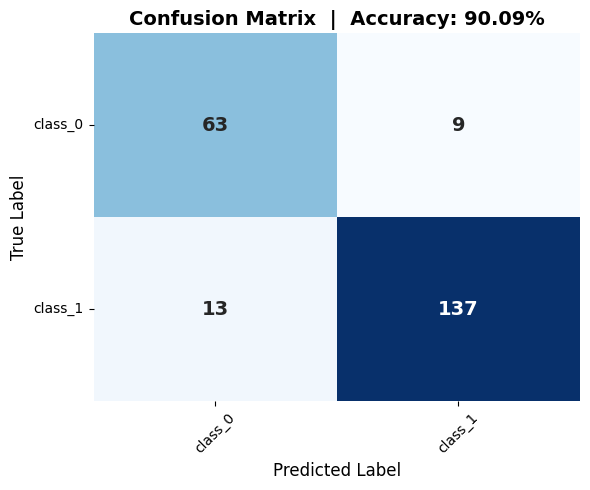

In [42]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
acc = (y_true == y_pred).mean() * 100

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=False,
    annot_kws={"size": 14, "weight": "bold"}
)
plt.title(f"Confusion Matrix  |  Accuracy: {acc:.2f}%", fontsize=14, weight="bold")
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Attack

In [18]:
# ---------------------------
# DataLoaders
# ---------------------------
batch_size = 1
ImageFile.LOAD_TRUNCATED_IMAGES = True

dl_train = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0)
dl_val   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
dl_test  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 1773, Val: 222, Test: 222


In [33]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [28]:
eps = 4/255.0        # L_inf epsilon
alpha = 1/255.0      # step size
steps = 10            # PGD steps
random_start = True  # random init inside L_inf ball

# CIFAR-10 normalization statistics (what your model expects)
CIFAR_MEAN = torch.tensor([0.4914, 0.4822, 0.4465])
CIFAR_STD = torch.tensor([0.2470, 0.2435, 0.2616])

# ---------- Helpers ----------
def _maybe_repeat_to_three(x):
    """If input has 1 channel, repeat to 3 channels (model expects 3)."""
    if x.dim() == 4 and x.size(1) == 1:
        return x.repeat(1, 3, 1, 1)
    return x

def pgd_linf_batch_simple(model, x_orig, y, eps, alpha, steps, random_start=True):
    """
    PGD attack for normalized images.
    x_orig: [B,C,H,W] - NORMALIZED images (using CIFAR-10 normalization)
    y: [B] long labels
    returns x_adv: adversarial examples in normalized space
    """
    device = x_orig.device
    
    # Get normalization parameters
    mean = CIFAR_MEAN.view(1, 3, 1, 1).to(device)
    std = CIFAR_STD.view(1, 3, 1, 1).to(device)
    
    # Calculate valid range in normalized space
    # (0 - mean) / std  to  (1 - mean) / std
    lower_limit = (0 - mean) / std
    upper_limit = (1 - mean) / std
    
    # Handle single-channel images
    if x_orig.size(1) == 1:
        lower_limit = lower_limit[:, 0:1, :, :]
        upper_limit = upper_limit[:, 0:1, :, :]
    
    x_orig = x_orig.detach()
    
    if random_start:
        x_adv = x_orig + torch.empty_like(x_orig).uniform_(-eps, eps)
        x_adv = torch.clamp(x_adv, lower_limit, upper_limit)
    else:
        x_adv = x_orig.clone().detach()
    
    loss_fn = nn.CrossEntropyLoss()
    
    for _ in range(steps):
        x_adv.requires_grad_()
        xin = _maybe_repeat_to_three(x_adv)
        logits = model(xin)
        loss = loss_fn(logits, y)
        
        model.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.data.zero_()
        loss.backward()
        
        grad = x_adv.grad.detach()
        x_adv = x_adv.detach() + alpha * torch.sign(grad)
        
        # Project to L_inf ball around original
        x_adv = torch.max(torch.min(x_adv, x_orig + eps), x_orig - eps)
        
        # Clamp to valid normalized range (not [0,1]!)
        x_adv = torch.clamp(x_adv, lower_limit, upper_limit)
    
    return x_adv.detach()

In [24]:
eps = 4/255.0        # L_inf epsilon
alpha = 1/255.0      # step size
steps = 10            # PGD steps
random_start = True  # random init inside L_inf ball

# CIFAR-10 stats (normalized space)
CIFAR_MEAN = torch.tensor([0.4914, 0.4822, 0.4465])
CIFAR_STD  = torch.tensor([0.2470, 0.2435, 0.2616])

def _maybe_repeat_to_three(x):
    # Avoids huge copies if already 3-channel
    if x.dim() == 4 and x.size(1) == 1:
        # Cheaper than repeat for many ops; if a layer requires contiguous,
        # PyTorch will materialize on demand.
        return x.expand(-1, 3, -1, -1)
    return x

def pgd_linf_batch_ultralite(
    model,
    x_orig,
    y,
    eps=4/255.0,
    alpha=1/255.0,
    steps=10,
    random_start=True,
    use_amp=True,
    use_checkpoint=False,   # set True if still OOM
):
    """
    Memory-friendly PGD in normalized space.
    - Only x_adv requires grad.
    - Uses autocast (AMP) to cut activation memory.
    - Optional checkpointing to avoid storing activations.
    """
    device = x_orig.device
    model.eval()
    for p in model.parameters():
        p.requires_grad_(False)

    mean = CIFAR_MEAN.view(1, 3, 1, 1).to(device)
    std  = CIFAR_STD.view(1, 3, 1, 1).to(device)

    lower = (0 - mean) / std
    upper = (1 - mean) / std
    if x_orig.size(1) == 1:
        lower = lower[:, 0:1]
        upper = upper[:, 0:1]

    x_orig = x_orig.detach()
    if random_start:
        x_adv = x_orig + torch.empty_like(x_orig).uniform_(-eps, eps)
        x_adv = torch.max(torch.min(x_adv, upper), lower)
    else:
        x_adv = x_orig.clone()

    loss_fn = nn.CrossEntropyLoss()

    # Choose precision context
    amp_ctx = torch.cuda.amp.autocast() if (use_amp and torch.cuda.is_available()) else nullcontext()

    for _ in range(steps):
        x_adv.requires_grad_(True)

        xin = _maybe_repeat_to_three(x_adv)

        # Optional checkpoint wrapper (saves activations, recomputes on backward)
        if use_checkpoint:
            from torch.utils.checkpoint import checkpoint
            # function must accept tensor and return tensor
            def _f(t):
                return model(t)
            with amp_ctx:
                logits = checkpoint(_f, xin, use_reentrant=False)
        else:
            with amp_ctx:
                logits = model(xin)

        loss = loss_fn(logits, y)

        # Autograd only for x_adv (no big .backward graph kept)
        grad = torch.autograd.grad(loss, x_adv, only_inputs=True, retain_graph=False, create_graph=False)[0]

        # PGD step
        x_adv = x_adv.detach() + alpha * grad.sign()

        # Project to L_inf ball and clamp to valid normalized range
        x_adv = torch.max(torch.min(x_adv, x_orig + eps), x_orig - eps)
        x_adv = torch.max(torch.min(x_adv, upper), lower)

        # Clean up ASAP
        del grad, logits, loss, xin
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return x_adv.detach()


In [20]:
def denormalize(img_tensor):
    """
    Denormalize image tensor using dataset mean/std (ImageNet or your dataset)
    img_tensor: [C,H,W] in torch tensor
    returns: [H,W,C] numpy in [0,1]
    """
    mean = np.array([0.4914, 0.4822, 0.4465])
    std  = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.numpy().transpose((1,2,0))  # CHW -> HWC
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def show_before_after(orig_batch, adv_batch, y_true, y_pred, class_names=None, n=6, figsize_per_img=(3,3)):
    """
    Display original, adversarial, and perturbation images in three rows.
    - orig_batch, adv_batch: torch tensors [B, C, H, W] in normalized form
    - y_true, y_pred: arrays/lists of labels (numeric)
    - class_names: list of class names (index -> name). If None, numeric labels are used.
    - n: number of samples to show (from start of batch)
    - figsize_per_img: tuple (width, height) in inches per image
    """
    # Convert to numpy
    if isinstance(orig_batch, torch.Tensor):
        orig = orig_batch.cpu().numpy()
    else:
        orig = np.array(orig_batch)
    if isinstance(adv_batch, torch.Tensor):
        adv = adv_batch.cpu().numpy()
    else:
        adv = np.array(adv_batch)

    B = orig.shape[0]
    n = min(n, B)
    w, h = figsize_per_img
    plt.figure(figsize=(n * w, h * 3))  # 3 rows, n columns

    for i in range(n):
        # --- Original (top row) ---
        ax = plt.subplot(3, n, i + 1)
        img_o = denormalize(torch.tensor(orig[i]))
        ax.imshow(img_o)
        true_label = (class_names[y_true[i]] if class_names is not None else str(y_true[i]))
        ax.set_title(f"Orig (t={true_label})", fontsize=10)
        ax.axis("off")

        # --- Adversarial (middle row) ---
        ax = plt.subplot(3, n, n + i + 1)
        img_a = denormalize(torch.tensor(adv[i]))
        ax.imshow(img_a)
        pred_label = (class_names[y_pred[i]] if class_names is not None else str(y_pred[i]))
        ax.set_title(f"Adv (p={pred_label})", fontsize=10)
        ax.axis("off")

        # --- Perturbation (bottom row) ---
        pert = img_a - img_o
        pert_min, pert_max = pert.min(), pert.max()
        pert_vis = np.where(pert_max != pert_min,
                            (pert - pert_min) / (pert_max - pert_min),
                            0.5)
        ax2 = plt.subplot(3, n, 2 * n + i + 1)
        ax2.imshow(pert_vis)
        ax2.set_title("Perturbation (Scaled)", fontsize=10)
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

In [21]:
# =========================================================
# 1️⃣  Define the model architecture (same as training)
# =========================================================
import torch
import torch.nn as nn
from robustarch.models.model_cifar import NormalizedWideResNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate RaWRN-70-16 architecture (exact same config as training)
depth = (30, 31, 10)
stage_width = (216, 432, 864)
groups = (1, 1, 1)

model = NormalizedWideResNet(
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2470, 0.2435, 0.2616),
    stem_width=96,
    depth=depth,
    stage_width=stage_width,
    groups=groups,
    activation_fn=nn.SiLU,
    se_ratio=0.25,
    se_activation=nn.ReLU,
    se_order=2,
    num_classes=10,  # we’ll replace classifier next
)

# =========================================================
# 2️⃣  Load pretrained backbone weights
# =========================================================
checkpoint_path = "/kaggle/working/xAI/ra_wrn70_16_cifar10.pt"
ckpt = torch.load(checkpoint_path, map_location="cpu")

# Remove old classifier weights (CIFAR-10 → 2 classes)
if "logits.weight" in ckpt:
    del ckpt["logits.weight"]
    del ckpt["logits.bias"]
model.load_state_dict(ckpt, strict=False)

# =========================================================
# 3️⃣  Replace the final classifier (same as training)
# =========================================================
last_name, last_module = None, None
for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        last_name, last_module = name, module
if last_module is None:
    raise ValueError("No nn.Linear layer found to replace")

in_features = last_module.in_features
new_classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 2),
)

# Replace the classifier in the model
parent = model
if "." in last_name:
    parts = last_name.split(".")
    for p in parts[:-1]:
        parent = getattr(parent, p)
    setattr(parent, parts[-1], new_classifier)
else:
    setattr(parent, last_name, new_classifier)

model = model.to(device)

# =========================================================
# 4️⃣  Download the best fine-tuned weights
# =========================================================
# -------------------------
# 2. Download and load from Hugging Face
# -------------------------
checkpoint_path = hf_hub_download(
    repo_id="HosseinRanjbar/XAI-Bone-Fracture-Xray-Robust-Principle-Model",
    filename="best_meansparse.pth"
)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
# model.eval()
print(f"✅ Loaded best fine-tuned weights from: {checkpoint_path}")

best_meansparse.pth:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

✅ Loaded best fine-tuned weights from: /root/.cache/huggingface/hub/models--HosseinRanjbar--XAI-Bone-Fracture-Xray-Robust-Principle-Model/snapshots/ea0c8fdeff6b52d16ca0dfa127c796080c207af1/best_meansparse.pth


In [30]:
# Use the notebook-friendly tqdm
try:
    from tqdm.notebook import tqdm   # works best in Kaggle/Jupyter
except ImportError:
    from tqdm.auto import tqdm

SHOW_PROGRESS = True   # flip False to silence the bar
LOG_EVERY = 0          # >0 if you want occasional postfix updates; 0 = never

all_adv_preds, all_adv_labels = [], []

model.eval()
for p in model.parameters():
    p.requires_grad_(False)

# IMPORTANT: iterate over *this* progress iterator; do not iterate over the dataloader separately
pbar = tqdm(
    dl_test,                          # your dataloader
    total=len(dl_test),               # ensure tqdm knows the length
    desc=f"PGD eps={eps} steps={steps}",
    leave=True,                       # keep one compact bar after finish
    dynamic_ncols=True,               # adapt to notebook width
    smoothing=0.0,                    # stable ETA
    mininterval=0.5,                  # throttle screen updates
    disable=not SHOW_PROGRESS,        # on/off switch
)

for i, (inputs, labels) in enumerate(pbar, start=1):
    # NEVER print inside this loop; it breaks the in-place bar
    inputs = inputs.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)

    # your memory-light PGD
    x_adv = pgd_linf_batch_ultralite(
        model, inputs, labels,
        eps=eps, alpha=alpha, steps=steps,
        random_start=random_start, use_amp=True, use_checkpoint=False
    )

    with torch.no_grad():
        logits_adv = model(_maybe_repeat_to_three(x_adv))
        preds_adv = torch.argmax(logits_adv, dim=1)

    all_adv_preds.append(preds_adv.cpu().numpy())
    all_adv_labels.append(labels.cpu().numpy())

    # OPTIONAL: update postfix only every N batches (prevents flicker/newlines)
    if LOG_EVERY and (i % LOG_EVERY == 0):
        pbar.set_postfix_str(f"done={i}/{len(dl_test)}")

    # cleanup
    del inputs, labels, x_adv, logits_adv, preds_adv
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Finalize results outside the loop
import numpy as np
all_adv_preds  = np.concatenate(all_adv_preds)
all_adv_labels = np.concatenate(all_adv_labels)

PGD eps=0.01568627450980392 steps=10:   0%|          | 0/222 [00:00<?, ?it/s]

/tmp/ipykernel_36/2072152813.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  amp_ctx = torch.cuda.amp.autocast() if (use_amp and torch.cuda.is_available()) else nullcontext()



=== Adversarial test set metrics (PGD L_inf eps=0.01568627450980392, steps=10) ===
Accuracy: 0.0450

Classification report (per-class + macro & weighted):
               precision    recall  f1-score   support

    fractured     0.0070    0.0139    0.0093        72
not fractured     0.1125    0.0600    0.0783       150

     accuracy                         0.0450       222
    macro avg     0.0598    0.0369    0.0438       222
 weighted avg     0.0783    0.0450    0.0559       222


Confusion matrix (rows=true, cols=pred):
[[  1  71]
 [141   9]]


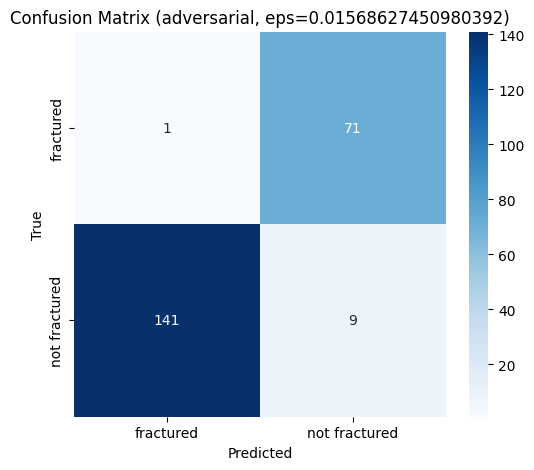


Macro-avg: precision=0.0598, recall=0.0369, f1=0.0438
Weighted-avg: precision=0.0783, recall=0.0450, f1=0.0559


In [31]:
# ---------- Compute & print metrics ----------
class_names = train_dataset.dataset.classes if hasattr(train_dataset, "dataset") else ['fractured', 'not fractured']
acc = accuracy_score(all_adv_labels, all_adv_preds)
report_dict = classification_report(all_adv_labels, all_adv_preds, target_names=class_names, digits=4, output_dict=True)
report_str = classification_report(all_adv_labels, all_adv_preds, target_names=class_names, digits=4)
cm = confusion_matrix(all_adv_labels, all_adv_preds)

print(f"\n=== Adversarial test set metrics (PGD L_inf eps={eps}, steps={steps}) ===")
print(f"Accuracy: {acc:.4f}\n")
print("Classification report (per-class + macro & weighted):")
print(report_str)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm)

# Confusion heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (adversarial, eps={eps})")
plt.show()

# Macro & weighted scores
macro_p = report_dict['macro avg']['precision']
macro_r = report_dict['macro avg']['recall']
macro_f1 = report_dict['macro avg']['f1-score']
w_p = report_dict['weighted avg']['precision']
w_r = report_dict['weighted avg']['recall']
w_f1 = report_dict['weighted avg']['f1-score']

print(f"\nMacro-avg: precision={macro_p:.4f}, recall={macro_r:.4f}, f1={macro_f1:.4f}")
print(f"Weighted-avg: precision={w_p:.4f}, recall={w_r:.4f}, f1={w_f1:.4f}")

/tmp/ipykernel_36/2072152813.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  amp_ctx = torch.cuda.amp.autocast() if (use_amp and torch.cuda.is_available()) else nullcontext()


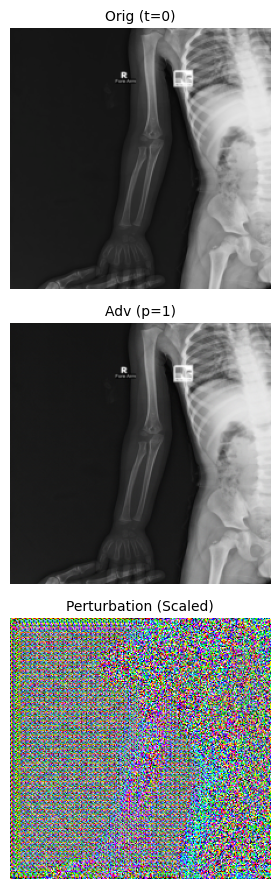

In [33]:
# -------------------------
# Example usage with one batch
# -------------------------
# get one small batch
inputs, labels = next(iter(dl_test))
# create adversarial batch (small n, e.g. steps=1)
x_adv = pgd_linf_batch_ultralite(model, inputs.to(device), labels.to(device), eps=eps, alpha=alpha, steps=steps, random_start=random_start)
with torch.no_grad():
    logits_adv = model(_maybe_repeat_to_three(x_adv))
    preds = torch.argmax(logits_adv, dim=1).cpu().numpy()

# choose class names from test dataset if available
class_names = test_dataset.classes if hasattr(test_dataset, "classes") else None

# show first 6 examples (or change n)
show_before_after(inputs, x_adv.cpu(), labels.numpy(), preds, class_names=class_names, n=6, figsize_per_img=(3.0, 3.0))